#  Regularized Polynomial Regression (Order 2) (OLS / Ridge / Lasso / ElasticNet) 

#### Speed specifications & Imports

In [91]:
#  SPEED HEADER (single-BLAS + joblib CV) 
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob (for Ryzen 7950X: 16–24; tune to your box)
N_JOBS = 18
RANDOM_STATE = 42

# Imports 
import warnings; warnings.filterwarnings("ignore")
import re
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from joblib import Parallel, delayed, dump
from threadpoolctl import threadpool_limits

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import TransformerMixin, BaseEstimator

import statsmodels.api as sm
from scipy.stats import f as f_dist 

#### Paths, Data Loading & Checks

In [92]:
#  Paths 
SAVE_DIR   = '../Extended Parametric Regression Files+Plots'   # or '.' if you prefer
TRAIN_CSV  = f'{SAVE_DIR}/train.csv'
TEST_CSV   = f'{SAVE_DIR}/test.csv'
FOLDS_NPY  = f'{SAVE_DIR}/train_folds.npy'   # must exist (precomputed)

# Output paths for models & residuals
MODELS_DIR = "../Extended Parametric Regression Files+Plots/Models/MLR"           # one CV-chosen best pipeline for MLR models
RESID_DIR  = "../Extended Parametric Regression Files+Plots/Reports/Residuals_Test"    # residuals per model (from the 80/20 test) 
RESID_DIR_OOF = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF"  # OOF Residuals

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESID_DIR,  exist_ok=True)
os.makedirs(RESID_DIR_OOF, exist_ok=True)

def slug(obj):
    """Filename-safe tag for params."""
    if isinstance(obj, dict) and obj:
        parts = []
        for k in sorted(obj.keys()):
            v = obj[k]
            if isinstance(v, (float, np.floating)): v = float(v)
            parts.append(f"{k}={v}")
        s = "__".join(parts)
    else:
        s = str(obj) if obj not in (None, {}, []) else ""
    return re.sub(r"[^A-Za-z0-9._=-]+", "_", s).strip("_")

def base_tag_from_name(name: str) -> str:
    """Map display name to a compact base tag."""
    if "Ridge" in name: return "Ridge"
    if "Lasso" in name: return "Lasso"
    if "ElasticNet" in name: return "ElasticNet"
    if "OLS" in name: return "OLS"
    return slug(name)

#  Load splits
# Preserve original row positions from the CSV (these match train_folds.npy)
df_train = pd.read_csv(TRAIN_CSV)
df_train["_rowpos"] = np.arange(len(df_train), dtype=int)
df_test  = pd.read_csv(TEST_CSV)

# down-sample for speed
#df_train = df_train.sort_values('time').reset_index(drop=True).iloc[::50].reset_index(drop=True)
#df_test  = df_test.sort_values('time').reset_index(drop=True).iloc[::50].reset_index(drop=True)

# Required columns check 
required_cols = [
    'PL','distance','frequency','c_walls','w_walls',
    'co2','humidity','pm25','pressure','temperature','snr'
]
missing = [c for c in required_cols if c not in df_train.columns or c not in df_test.columns]
if missing:
    raise ValueError(f"Missing required columns in train/test: {missing}")

#### Cross-Validation Folds

In [93]:
fold_assignments_full = np.load(FOLDS_NPY)  # vector aligned to ORIGINAL train.csv order

# Remap saved folds to the CURRENT df_train order/selection (works even if you sorted/filtered above)
rowpos = df_train["_rowpos"].to_numpy(dtype=int)
if rowpos.max() >= len(fold_assignments_full):
    raise ValueError(
        f"[folds] Mismatch: train_folds.npy len={len(fold_assignments_full)} < max(_rowpos)={rowpos.max()}.\n"
        f"train.csv and train_folds.npy are out of sync."
    )
fold_assignments = fold_assignments_full[rowpos]

# Build (train_idx, val_idx) pairs from the remapped folds
K = int(fold_assignments.max()) + 1
folds = [(np.where(fold_assignments != k)[0], np.where(fold_assignments == k)[0]) for k in range(K)]

print(f"[CV] Using saved folds (remapped) | K={K} | n_train={len(df_train)} | "
      f"fold sizes={[len(v) for _, v in folds]}")

[CV] Using saved folds (remapped) | K=5 | n_train=1415913 | fold sizes=[283183, 283183, 283183, 283182, 283182]


#### Physics, Features & Metrics

In [94]:
# Physics helpers 
d0 = 1.0  # reference distance in meters

def z_of_d(d):
    d = np.clip(d.astype(float), 1e-6, None)
    return 10.0 * np.log10(d / d0)

def f_term(f):
    f = np.clip(f.astype(float), 1e-12, None)
    return 20.0 * np.log10(f)

#  Features & targets 
raw_feats  = ['distance','frequency','c_walls','w_walls',
              'co2','humidity','pm25','pressure','temperature','snr']
target_col = 'PL'

Xtr_raw = df_train[raw_feats].copy()
ytr_pl  = df_train[target_col].astype(float).values
Xte_raw = df_test[raw_feats].copy()
yte_pl  = df_test[target_col].astype(float).values

# Friis adjustment: y_adj = PL - 20*log10(f)
ftr_tr, ftr_te = f_term(Xtr_raw['frequency'].values), f_term(Xte_raw['frequency'].values)
ytr_adj, yte_adj = ytr_pl - ftr_tr, yte_pl - ftr_te

# Base linearized matrix (order matters for the polynomial transformer)
LIN_COLS = ['z_d','c_walls','w_walls','co2','humidity','pm25','pressure','temperature','snr']

Xtr_lin = pd.DataFrame({
    'z_d': z_of_d(Xtr_raw['distance'].values),
    'c_walls': Xtr_raw['c_walls'].values,
    'w_walls': Xtr_raw['w_walls'].values,
    'co2': Xtr_raw['co2'].values,
    'humidity': Xtr_raw['humidity'].values,
    'pm25': Xtr_raw['pm25'].values,
    'pressure': Xtr_raw['pressure'].values,
    'temperature': Xtr_raw['temperature'].values,
    'snr': Xtr_raw['snr'].values
}, columns=LIN_COLS).values

Xte_lin = pd.DataFrame({
    'z_d': z_of_d(Xte_raw['distance'].values),
    'c_walls': Xte_raw['c_walls'].values,
    'w_walls': Xte_raw['w_walls'].values,
    'co2': Xte_raw['co2'].values,
    'humidity': Xte_raw['humidity'].values,
    'pm25': Xte_raw['pm25'].values,
    'pressure': Xte_raw['pressure'].values,
    'temperature': Xte_raw['temperature'].values,
    'snr': Xte_raw['snr'].values
}, columns=LIN_COLS).values

#  Metrics (PL-domain)
def rmse_r2_on_PL(y_true_pl, y_pred_adj, fterm):
    # Convert predictions back to PL-domain using the frequency term of each split
    y_pred_pl = y_pred_adj + fterm
    rmse = sqrt(((y_true_pl - y_pred_pl) ** 2).mean())
    ss_res = ((y_true_pl - y_pred_pl) ** 2).sum()
    ss_tot = ((y_true_pl - y_true_pl.mean()) ** 2).sum()
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return rmse, r2

#### Polynomial Feature Transformer

In [95]:
POLY_KEEP_LINEAR_IDXS = [1, 2]                # keep c_walls, w_walls linear
POLY_EXPAND_IDXS      = [0, 3, 4, 5, 6, 7, 8] # expand z_d + env + snr

class PolyOnContinuous(TransformerMixin, BaseEstimator):
    """
    Degree-2 PolynomialFeatures on selected columns (expand_idxs) and
    concatenate kept linear columns (keep_idxs) in front.
    Produces feature names for reporting.
    """
    def __init__(self, keep_idxs=POLY_KEEP_LINEAR_IDXS, expand_idxs=POLY_EXPAND_IDXS, degree=2, all_names=LIN_COLS):
        self.keep_idxs   = list(keep_idxs)
        self.expand_idxs = list(expand_idxs)
        self.degree      = int(degree)
        self.all_names   = list(all_names)
        self.poly_       = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        in_names = [self.all_names[i] for i in self.expand_idxs]
        self.poly_ = PolynomialFeatures(self.degree, include_bias=False).fit(X[:, self.expand_idxs])
        keep_names = [self.all_names[i] for i in self.keep_idxs]
        poly_names = self.poly_.get_feature_names_out(in_names).tolist()
        # cosmetic: ^2 → ²
        poly_names = [n.replace("^2", "²") for n in poly_names]
        self.feature_names_out_ = keep_names + poly_names
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_lin  = X[:, self.keep_idxs]
        X_poly = self.poly_.transform(X[:, self.expand_idxs])
        return np.hstack([X_lin, X_poly])

    def get_feature_names_out(self):
        if self.feature_names_out_ is None:
            raise RuntimeError("Call fit() before get_feature_names_out().")
        return np.array(self.feature_names_out_, dtype=object)

# Model Factories and Grids 
def make_PolyOLS(_):
    return make_pipeline(
        PolyOnContinuous(),
        LinearRegression()
    )

def make_PolyRidge(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        Ridge(alpha=cfg["alpha"], random_state=RANDOM_STATE)
    )

def make_PolyLasso(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        Lasso(alpha=cfg["alpha"], max_iter=20000, random_state=RANDOM_STATE)
    )

def make_PolyENet(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        ElasticNet(alpha=cfg["alpha"], l1_ratio=cfg["l1_ratio"], max_iter=20000, random_state=RANDOM_STATE)
    )

ridge_grid = [dict(alpha=a) for a in np.logspace(-4, 3, 15)]
lasso_grid = [dict(alpha=a) for a in np.logspace(-4, 1, 15)]
enet_grid  = [dict(alpha=a, l1_ratio=r) for a in np.logspace(-4, 1, 10) for r in (0.2, 0.5, 0.8)]

poly_specs = [
    ("Poly-OLS (deg2)",        make_PolyOLS,  [dict()]),
    ("Poly-Ridge (deg2)",      make_PolyRidge, ridge_grid),
    ("Poly-Lasso (deg2)",      make_PolyLasso, lasso_grid),
    ("Poly-ElasticNet (deg2)", make_PolyENet,  enet_grid),
]

# Unscale coefficients (poly basis) for reporting
def unscale_poly_coeffs(pipeline):
    """
    Undo StandardScaler in pipeline [PolyOnContinuous, (StandardScaler?), Estimator].
    Returns: intercept, beta vector, feature_names
    """
    steps = pipeline.named_steps
    transformer = steps['polyoncontinuous']
    feat_names = transformer.get_feature_names_out().tolist()
    est = steps.get('ridge') or steps.get('lasso') or steps.get('elasticnet') or steps.get('linearregression')

    if 'standardscaler' not in steps:
        return float(est.intercept_), est.coef_.astype(float).copy(), feat_names

    scaler = steps['standardscaler']
    beta_scaled = est.coef_.astype(float)
    mu, sig = scaler.mean_, scaler.scale_
    beta_orig = beta_scaled / sig
    intercept_orig = float(est.intercept_ - np.sum(beta_scaled * mu / sig))
    return intercept_orig, beta_orig, feat_names

#### Cross-Validation and Final Fit

In [96]:
# Cross-validation and evaluation
def eval_cfg_poly(factory, cfg, folds):
    tr_rmse_list, val_rmse_list, tr_r2_list, val_r2_list = [], [], [], []
    for tr_idx, val_idx in folds:
        X_tr, X_val = Xtr_lin[tr_idx], Xtr_lin[val_idx]
        y_tr, y_val = ytr_adj[tr_idx], ytr_adj[val_idx]
        ypl_tr, ypl_val = ytr_pl[tr_idx], ytr_pl[val_idx]
        f_tr,  f_val    = ftr_tr[tr_idx],  ftr_tr[val_idx]

        pipe = factory(cfg)
        with threadpool_limits(limits=1, user_api="blas"):
            pipe.fit(X_tr, y_tr)

        y_tr_pred_adj = pipe.predict(X_tr)
        rmse_tr, r2_tr = rmse_r2_on_PL(ypl_tr, y_tr_pred_adj, f_tr)
        tr_rmse_list.append(rmse_tr); tr_r2_list.append(r2_tr)

        y_val_pred_adj = pipe.predict(X_val)
        rmse_val, r2_val = rmse_r2_on_PL(ypl_val, y_val_pred_adj, f_val)
        val_rmse_list.append(rmse_val); val_r2_list.append(r2_val)

    return {
        "cfg": cfg,
        "rmse_train_mean": float(np.mean(tr_rmse_list)), "rmse_train_sd": float(np.std(tr_rmse_list)),
        "rmse_val_mean":   float(np.mean(val_rmse_list)), "rmse_val_sd":   float(np.std(val_rmse_list)),
        "r2_train_mean":   float(np.mean(tr_r2_list)),    "r2_train_sd":    float(np.std(tr_r2_list)),
        "r2_val_mean":     float(np.mean(val_r2_list)),   "r2_val_sd":      float(np.std(val_r2_list)),
    }

poly_results = []
residuals_list = []  # collect per-model test residuals

for name, factory, grid in poly_specs:
    print(f"=== {name} — grid size: {len(grid)}")
    if len(grid) == 1:
        grid_results = [eval_cfg_poly(factory, grid[0], folds)]
    else:
        grid_results = Parallel(n_jobs=N_JOBS, backend="threading", prefer="threads", verbose=0)(
            delayed(eval_cfg_poly)(factory, cfg, folds) for cfg in grid
        )

    best_res = min(grid_results, key=lambda r: r["rmse_val_mean"])
    best_cfg, best_cv = best_res["cfg"], {k: v for k, v in best_res.items() if k != "cfg"}
    print(f"Best (Val RMSE): {best_cv['rmse_val_mean']:.4f} ± {best_cv['rmse_val_sd']:.4f} | cfg={best_cfg}")

    # Refit on all training data with best hyperparams
    final_pipe = factory(best_cfg)
    with threadpool_limits(limits=1, user_api="blas"):
        final_pipe.fit(Xtr_lin, ytr_adj)

    # Test (PL domain)
    yte_pred_adj = final_pipe.predict(Xte_lin)
    test_rmse, test_r2 = rmse_r2_on_PL(yte_pl, yte_pred_adj, ftr_te)

    # ---- NEW: residuals on the 20% test split (uniform schema) ----
    PL_pred  = yte_pred_adj + ftr_te
    resid_db = yte_pl - PL_pred

    base_tag = base_tag_from_name(name)                 # e.g., "Ridge"
    tag_cfg  = slug(best_cfg)                           # e.g., "alpha=0.1"
    model_tag = f"POLY2_{base_tag}" if tag_cfg == "" else f"POLY2_{base_tag}__{tag_cfg}"

    res_df = pd.DataFrame({
        "model":       model_tag,
        "split":       "test",
        "row_id":      np.arange(len(df_test), dtype=int),
        "time":        df_test.get("time", pd.Series(index=df_test.index, dtype=float)),
        "distance":    df_test["distance"].values,
        "frequency":   df_test["frequency"].values,
        "c_walls":     df_test["c_walls"].values,
        "w_walls":     df_test["w_walls"].values,
        "co2":         df_test["co2"].values,
        "humidity":    df_test["humidity"].values,
        "pm25":        df_test["pm25"].values,
        "pressure":    df_test["pressure"].values,
        "temperature": df_test["temperature"].values,
        "snr":         df_test["snr"].values,
        "PL_true":     yte_pl,
        "PL_pred":     PL_pred,
        "resid_db":    resid_db
    })
    residuals_list.append((model_tag, res_df))

    # Coefficients in polynomial basis (de-scaled if needed)
    intercept_orig, beta_orig, feat_names = unscale_poly_coeffs(final_pipe)
    coeffs = np.concatenate(([intercept_orig], beta_orig))
    coeff_idx = ["Intercept"] + feat_names
    coeffs_series = pd.Series(coeffs, index=coeff_idx, name=name)

    poly_results.append({
        "model": name,
        "best_cfg": best_cfg,
        "cv": best_cv,
        "test": {"rmse": float(test_rmse), "r2": float(test_r2)},
        "coeffs": coeffs_series,
        "feature_names": feat_names,
        "final_pipe": final_pipe,
        "model_tag": model_tag
    })

print("Done.")

=== Poly-OLS (deg2) — grid size: 1
Best (Val RMSE): 7.1705 ± 0.0161 | cfg={}
=== Poly-Ridge (deg2) — grid size: 15
Best (Val RMSE): 7.1705 ± 0.0161 | cfg={'alpha': np.float64(1.0)}
=== Poly-Lasso (deg2) — grid size: 15
Best (Val RMSE): 7.1705 ± 0.0161 | cfg={'alpha': np.float64(0.0001)}
=== Poly-ElasticNet (deg2) — grid size: 30
Best (Val RMSE): 7.1706 ± 0.0160 | cfg={'alpha': np.float64(0.0001), 'l1_ratio': 0.8}
Done.


#### Save best POLY2 pipeline + residuals (CSV) 

In [97]:
# Best-of-family (POLY2) by mean Val RMSE (no test peeking)
best_overall = min(poly_results, key=lambda r: r["cv"]["rmse_val_mean"])
best_pipe = best_overall["final_pipe"]
best_tag  = best_overall["model_tag"]         # e.g., "POLY2_Ridge__alpha=0.1"
pipe_path = f"{MODELS_DIR}/{best_tag}.joblib"
dump(best_pipe, pipe_path)
print(f"[Models] Saved best POLY2 pipeline: {pipe_path}")

# Residuals per model (CSV only) on the 20% test split
for tag, df_res in residuals_list:
    out_path = f"{RESID_DIR}/residuals__{tag}__test.csv"
    df_res.to_csv(out_path, index=False)
    print(f"[Residuals] Saved (csv): {out_path}")

# Canonical alias for the chosen/best POLY2 model (easier for SF/FM consumption)
best_alias_path = f"{RESID_DIR}/residuals__POLY2__BEST__test.csv"
best_res_df = next(df for tag, df in residuals_list if tag == best_tag)
best_res_df.to_csv(best_alias_path, index=False)
print(f"[Residuals] Saved (csv, alias for BEST): {best_alias_path}")

# OOF residuals for BEST POLY2 model 
# Build OOF predictions using the same CV folds, train-only (for GMM selection).
best_model_name   = best_overall["model"]                 # matches names used in poly_specs
best_cfg          = best_overall["best_cfg"]
factory_for_best  = next(f for (n, f, g) in poly_specs if n == best_model_name)

K = int(np.max(fold_assignments)) + 1
y_pred_adj_oof = np.empty_like(ytr_adj, dtype=float)

for k in range(K):
    tr_idx = np.where(fold_assignments != k)[0]
    val_idx = np.where(fold_assignments == k)[0]
    pipe = factory_for_best(best_cfg)
    with threadpool_limits(limits=1, user_api="blas"):
        pipe.fit(Xtr_lin[tr_idx], ytr_adj[tr_idx])
    y_pred_adj_oof[val_idx] = pipe.predict(Xtr_lin[val_idx])

PL_pred_oof = y_pred_adj_oof + ftr_tr
resid_oof   = ytr_pl - PL_pred_oof

res_oof_df = pd.DataFrame({
    "model":       best_tag,  # e.g., "POLY2_Ridge__alpha=0.1"
    "split":       "oof",
    "row_id":      np.arange(len(df_train), dtype=int),
    "fold":        fold_assignments.astype(int),
    "time":        df_train.get("time", pd.Series(index=df_train.index, dtype=float)),
    "distance":    df_train["distance"].values,
    "frequency":   df_train["frequency"].values,
    "c_walls":     df_train["c_walls"].values,
    "w_walls":     df_train["w_walls"].values,
    "co2":         df_train["co2"].values,
    "humidity":    df_train["humidity"].values,
    "pm25":        df_train["pm25"].values,
    "pressure":    df_train["pressure"].values,
    "temperature": df_train["temperature"].values,
    "snr":         df_train["snr"].values,
    "PL_true":     ytr_pl,
    "PL_pred":     PL_pred_oof,
    "resid_db":    resid_oof
})

oof_path = f"{RESID_DIR_OOF}/residuals__{best_tag}__oof.csv"
res_oof_df.to_csv(oof_path, index=False)
print(f"[Residuals] Saved OOF residuals (POLY2 best): {oof_path}")

# Canonical alias for POLY2 BEST
best_oof_alias = f"{RESID_DIR_OOF}/residuals__POLY2__BEST__oof.csv"
res_oof_df.to_csv(best_oof_alias, index=False)
print(f"[Residuals] Saved (csv, alias for POLY2 BEST OOF): {best_oof_alias}")

[Models] Saved best POLY2 pipeline: ../Extended Parametric Regression Files+Plots/Models/MLR/POLY2_Ridge__alpha=1.0.joblib
[Residuals] Saved (csv): ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2_OLS__test.csv
[Residuals] Saved (csv): ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2_Ridge__alpha=1.0__test.csv
[Residuals] Saved (csv): ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2_Lasso__alpha=0.0001__test.csv
[Residuals] Saved (csv): ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2_ElasticNet__alpha=0.0001__l1_ratio=0.8__test.csv
[Residuals] Saved (csv, alias for BEST): ../Extended Parametric Regression Files+Plots/Reports/Residuals_Test/residuals__POLY2__BEST__test.csv
[Residuals] Saved OOF residuals (POLY2 best): ../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2_Ridge__alpha=1.0__oof.csv
[Residuals] S

#### CV Summary Table

In [98]:
def fmt(mu, sd): 
    return f"{mu:.4f} ± {sd:.4f}"

cv_rows = []
for res in poly_results:
    cv = res['cv']
    cv_rows.append({
        "Model":       res['model'],
        "RMSE (Train)": fmt(cv["rmse_train_mean"], cv["rmse_train_sd"]),
        "RMSE (Val)":   fmt(cv["rmse_val_mean"],   cv["rmse_val_sd"]),
        "R2 (Train)":   fmt(cv["r2_train_mean"],   cv["r2_train_sd"]),
        "R2 (Val)":     fmt(cv["r2_val_mean"],     cv["r2_val_sd"]),
    })
cv_poly_df = pd.DataFrame(cv_rows)
print("\n=== Cross-Validation Results (degree-2 polynomial features) ===")
display(cv_poly_df)


=== Cross-Validation Results (degree-2 polynomial features) ===


,Model,RMSE (Train),RMSE (Val),R2 (Train),R2 (Val)
0,Poly-OLS (deg2),7.1700 ± 0.0040,7.1705 ± 0.0161,0.8555 ± 0.0001,0.8555 ± 0.0006
1,Poly-Ridge (deg2),7.1700 ± 0.0040,7.1705 ± 0.0161,0.8555 ± 0.0001,0.8555 ± 0.0006
2,Poly-Lasso (deg2),7.1701 ± 0.0040,7.1705 ± 0.0161,0.8555 ± 0.0001,0.8555 ± 0.0006
3,Poly-ElasticNet (deg2),7.1702 ± 0.0040,7.1706 ± 0.0160,0.8555 ± 0.0001,0.8555 ± 0.0006


####  Block ANOVA and Nested Model Analysis

In [99]:
probe = PolyOnContinuous().fit(Xtr_lin)
X_poly_full = probe.transform(Xtr_lin)                 # columns: [walls_linear, poly(expand set)]
poly_names  = probe.get_feature_names_out().tolist()   # 'c_walls','w_walls', then z_d, z_d², co2, co2², ..., z_d co2, ...
W_idx = [0, 1]  # walls kept linear by construction (first 2 columns)
poly_part_names = poly_names[2:]
poly_part_idx   = list(range(2, X_poly_full.shape[1]))
name2col = dict(zip(poly_names, range(len(poly_names))))

def is_interaction(name):
    return (" " in name) or ("*" in name) or (":" in name)

DIST = {'z_d'}
ENV  = {'co2','humidity','pm25','pressure','temperature'}
SNR  = {'snr'}

S_idx, E_idx, N_idx, X_idx = [], [], [], []
for n in poly_part_names:
    j = name2col[n]
    if is_interaction(n):
        X_idx.append(j)
    else:
        base = n.replace('²','').replace('^2','')
        if base in DIST:
            S_idx.append(j)
        elif base in ENV:
            E_idx.append(j)
        elif base in SNR:
            N_idx.append(j)

blocks = {
    "W (walls)": W_idx,
    "S (z_d & z_d²)": S_idx,
    "E (env only)": E_idx,
    "N (snr & snr²)": N_idx,
    "X (all interactions)": X_idx
}
print("Block sizes:", {k: len(v) for k,v in blocks.items()})

def fit_ols_with_const(X, y):
    Xc = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, Xc).fit()

nested_order = ["W (walls)", "S (z_d & z_d²)", "E (env only)", "N (snr & snr²)", "X (all interactions)"]

X_blocks = []
cols_carry = []
for step in nested_order:
    cols_carry += blocks[step]
    X_blocks.append(np.asarray(X_poly_full[:, cols_carry], dtype=float))

yA = ytr_adj.copy()

print("\n=== Nested block tests (train; degree-2 basis; PL_adj target) ===")
df_display = []
prev_res = None
for i, X_now in enumerate(X_blocks):
    res_now = fit_ols_with_const(X_now, yA)
    if i == 0:
        prev_res = res_now
        continue
    RSS_R, RSS_F = np.sum(prev_res.resid**2), np.sum(res_now.resid**2)
    df_R,  df_F  = int(prev_res.df_resid),   int(res_now.df_resid)
    df_num = df_R - df_F
    df_den = df_F
    num = (RSS_R - RSS_F) / max(df_num, 1)
    den = (RSS_F / max(df_den, 1))
    F_stat = num / den if den > 0 else np.nan
    p_val  = 1 - f_dist.cdf(F_stat, df_num, df_den) if np.isfinite(F_stat) else np.nan
    partial_eta2 = (F_stat * df_num) / (F_stat * df_num + df_den) if np.isfinite(F_stat) else np.nan

    add_block = nested_order[i]
    df_display.append({
        "Add block": add_block, "Δdf": df_num,
        "F": F_stat, "p": p_val, "partial η²": partial_eta2
    })
    prev_res = res_now

anova_nested_df = pd.DataFrame(df_display)
display(anova_nested_df)

Block sizes: {'W (walls)': 2, 'S (z_d & z_d²)': 2, 'E (env only)': 10, 'N (snr & snr²)': 2, 'X (all interactions)': 21}

=== Nested block tests (train; degree-2 basis; PL_adj target) ===


,Add block,Δdf,F,p,partial η²
0,S (z_d & z_d²),2,148824.920128,1.110223e-16,0.173703
1,E (env only),10,857.307700,1.110223e-16,0.006018
2,N (snr & snr²),2,754445.074205,1.110223e-16,0.515898
3,X (all interactions),21,6911.116977,1.110223e-16,0.092974


#### Drop-One Block ANOVA

In [100]:
full_cols = []
for step in ["W (walls)", "S (z_d & z_d²)", "E (env only)", "N (snr & snr²)", "X (all interactions)"]:
    full_cols += blocks[step]
X_full = X_poly_full[:, full_cols]
res_full = sm.OLS(yA, sm.add_constant(X_full, has_constant='add')).fit()
RSS_full, df_full = np.sum(res_full.resid**2), int(res_full.df_resid)

rows = []
for blk_name, blk_cols in blocks.items():
    keep_cols = [c for c in full_cols if c not in blk_cols]
    X_drop = X_poly_full[:, keep_cols]
    res_drop = sm.OLS(yA, sm.add_constant(X_drop, has_constant='add')).fit()
    RSS_R, df_R = np.sum(res_drop.resid**2), int(res_drop.df_resid)
    df_num = df_R - df_full
    df_den = df_full
    num = (RSS_R - RSS_full) / max(df_num, 1)
    den = (RSS_full / max(df_den, 1))
    F_stat = num / den if den > 0 else np.nan
    p_val  = 1 - f_dist.cdf(F_stat, df_num, df_den) if np.isfinite(F_stat) else np.nan
    partial_eta2 = (F_stat * df_num) / (F_stat * df_num + df_den) if np.isfinite(F_stat) else np.nan
    rows.append({"Dropped block": blk_name, "Δdf": df_num, "F": F_stat, "p": p_val, "partial η²": partial_eta2})

anova_dropone_df = pd.DataFrame(rows).sort_values("p")
print("\n=== Drop-one partial-F vs Full (degree-2 polynomial basis) ===")
display(anova_dropone_df)


=== Drop-one partial-F vs Full (degree-2 polynomial basis) ===


,Dropped block,Δdf,F,p,partial η²
0,W (walls),2,156628.852448,1.110223e-16,0.181165
1,S (z_d & z_d²),2,15403.125164,1.110223e-16,0.021294
2,E (env only),10,285.176758,1.110223e-16,0.002010
3,N (snr & snr²),2,106156.183909,1.110223e-16,0.130398
4,X (all interactions),21,6911.116977,1.110223e-16,0.092974


#### Top-N Absolute Coefficient Plot 


BEST POLY2 MODEL: Poly-Lasso (deg2) | cfg={'alpha': np.float64(0.0001)}
=== Coefficients (original units) — full vector ===


,coef
Intercept,179.936539
c_walls,6.549609
w_walls,1.102091
z_d,-6.469721
co2,-0.002416
humidity,-0.558380
pm25,1.630122
pressure,-0.533810
temperature,-1.824020
snr,-5.053415


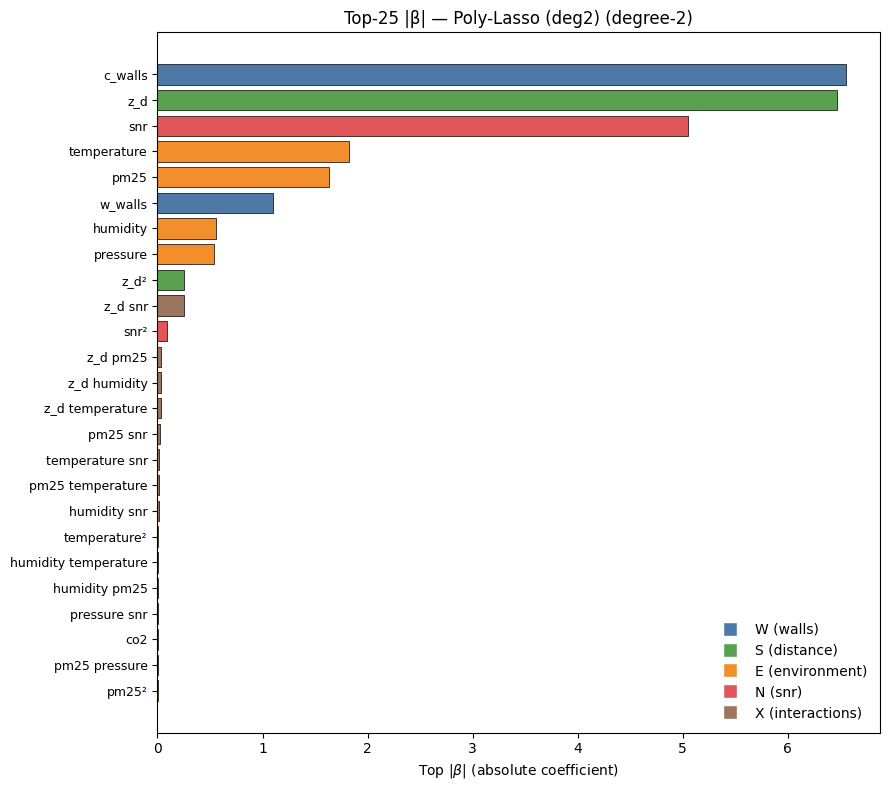

In [101]:
best = min(poly_results, key=lambda r: r['test']['rmse'])
coef_ser = best['coeffs']                  # index: ["Intercept", ..., feature names]; values: coefficients

# PRINT: full coefficients (BEST model) B
print(f"\nBEST POLY2 MODEL: {best['model']} | cfg={best['best_cfg']}")
print("=== Coefficients (original units) — full vector ===")
display(coef_ser.to_frame('coef').round(6))

names = coef_ser.index.tolist()[1:]        # drop intercept
coefs = coef_ser.values[1:]
feat_names = names

def is_interaction(name):
    return (' ' in name) or ('*' in name) or (':' in name)

def block_of(term):
    if term in ('c_walls','w_walls'):
        return 'W (walls)'
    if is_interaction(term):
        return 'X (interactions)'
    base = term.replace('²','').replace('^2','')
    if base == 'z_d':
        return 'S (distance)'
    if base in {'co2','humidity','pm25','pressure','temperature'}:
        return 'E (environment)'
    if base == 'snr':
        return 'N (snr)'
    return 'X (interactions)'

blocks = [block_of(t) for t in feat_names]
abs_coefs = np.abs(coefs)

TOPN = 25 if len(abs_coefs) >= 25 else len(abs_coefs)
top_idx = np.argsort(-abs_coefs)[:TOPN]
top_names  = [feat_names[i] for i in top_idx]
top_blocks = [blocks[i] for i in top_idx]
top_vals   = abs_coefs[top_idx]

color_map = {
    'W (walls)':        '#4e79a7',
    'S (distance)':     '#59a14f',
    'E (environment)':  '#f28e2b',
    'N (snr)':          '#e15759',
    'X (interactions)': '#9c755f',
}
colors = [color_map[b] for b in top_blocks]

plt.figure(figsize=(9, 8))
ypos = np.arange(TOPN)
plt.barh(ypos, top_vals, color=colors, edgecolor='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.yticks(ypos, top_names, fontsize=9)
plt.xlabel(r'Top $|\beta|$ (absolute coefficient)')
plt.title(f"Top-{TOPN} |β| — {best['model']} (degree-2)")
handles = []
for b, c in color_map.items():
    handles.append(plt.Line2D([0],[0], marker='s', color='w', markerfacecolor=c, markersize=10, label=b))
plt.legend(handles=handles, frameon=False, loc='lower right')
plt.tight_layout()
plt.show()

#### Interaction Coefficient Heatmap

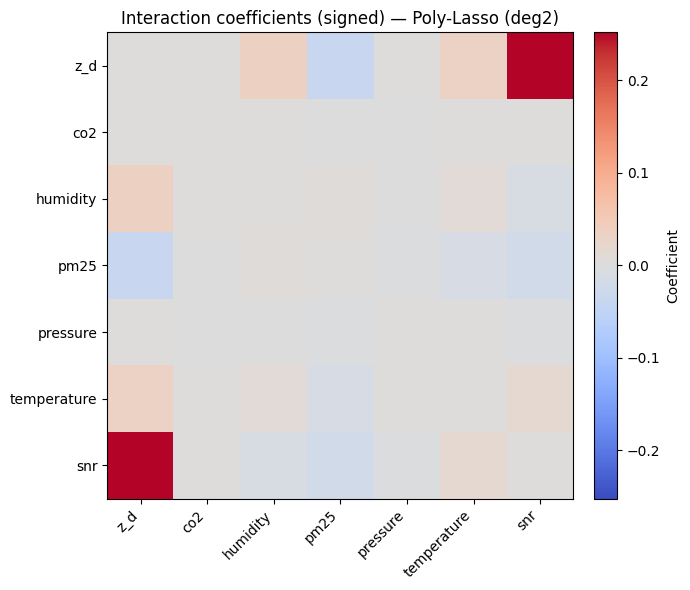

In [102]:
names = coef_ser.index.tolist()[1:]   # drop intercept
coefs = coef_ser.values[1:]

def is_interaction(name):
    return (' ' in name) or ('*' in name) or (':' in name)

base_vars = ['z_d','co2','humidity','pm25','pressure','temperature','snr']
v2i = {v:i for i,v in enumerate(base_vars)}
M = np.zeros((len(base_vars), len(base_vars)))

for name, coef in zip(names, coefs):
    if is_interaction(name):
        parts = name.replace('*',' ').replace(':',' ').split()
        if len(parts) == 2:
            a, b = parts
            a = a.replace('²','').replace('^2','')
            b = b.replace('²','').replace('^2','')
            if a in v2i and b in v2i:
                i, j = v2i[a], v2i[b]
                M[i, j] = coef
                M[j, i] = coef

v = np.max(np.abs(M)) if np.max(np.abs(M)) > 0 else 1.0

plt.figure(figsize=(6.8, 6))
im = plt.imshow(M, cmap='coolwarm', vmin=-v, vmax=v)
plt.xticks(range(len(base_vars)), base_vars, rotation=45, ha='right')
plt.yticks(range(len(base_vars)), base_vars)
plt.title(f"Interaction coefficients (signed) — {best['model']}")
plt.colorbar(im, fraction=0.046, pad=0.04, label='Coefficient')
plt.tight_layout()
plt.show()

#### Block Importance Bar Plot

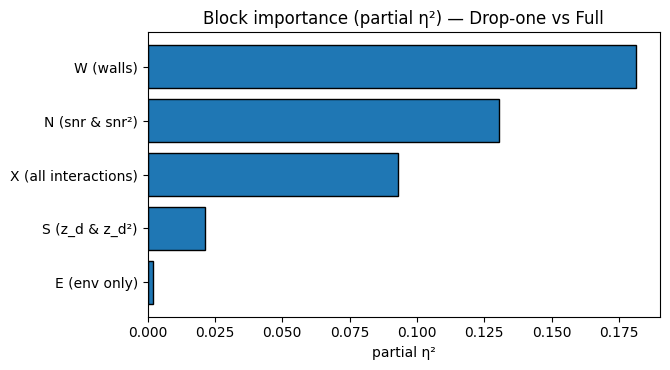

In [103]:
if 'anova_dropone_df' in globals():
    df_plot = anova_dropone_df[['Dropped block','partial η²']].copy()
    df_plot.rename(columns={'Dropped block':'Block'}, inplace=True)
    title = "Block importance (partial η²) — Drop-one vs Full"
elif 'anova_nested_df' in globals():
    df_plot = anova_nested_df[['Add block','partial η²']].copy()
    df_plot.rename(columns={'Add block':'Block'}, inplace=True)
    title = "Block importance (partial η²) — Nested build-up"
else:
    df_plot = None

if df_plot is not None:
    df_plot = df_plot.sort_values('partial η²', ascending=True)
    plt.figure(figsize=(6.8, 3.8))
    plt.barh(df_plot['Block'], df_plot['partial η²'], edgecolor='black')
    plt.xlabel('partial η²')
    plt.title(title)
    plt.tight_layout()
    plt.show()
else:
    print("ANOVA tables not found in memory; run the ANOVA cells first to plot partial η².")